# Lab 4: Color Perception and Color Spaces

**Computer Vision Course**

In this lab you will explore how different color spaces (RGB, HSV, HLS, Lab) affect image processing tasks. You'll see why simply working with RGB values is often not enough, and how choosing the right color space can make segmentation tasks much easier.

**What you'll do:**
- Segment the sky from an image using different color spaces
- Understand HSV, HLS, and Lab color representations
- Learn when each color space is useful
- Debug common color conversion issues

**Connection to previous labs:**
- Lab 3 showed how image variations break models
- Today you'll learn about one critical type of variation: **color**
- Understanding color spaces is essential for robust computer vision

## Setup

In [1]:
"""
Computer Vision Course - Lab 4: Color Perception

This cell sets up the environment.
Works automatically for both local and Google Colab!
"""

import os
import sys

# Detect environment
IN_COLAB = 'google.colab' in sys.modules

print("=" * 60)
print("Computer Vision - Lab 4: Color Perception")
print("=" * 60)

if IN_COLAB:
    print("\n🔵 Running on Google Colab")
    print("-" * 60)
    
    if not os.path.exists('computer-vision'):
        print("📥 Cloning repository...")
        !git clone https://github.com/mjck/computer-vision.git
        print("✓ Repository cloned successfully")
    else:
        !git -C computer-vision pull
        print("✓ Repository updated")
    
    %cd computer-vision/labs/lab04_color_perception
    print(f"✓ Current directory: {os.getcwd()}")
    
    sys.path.insert(0, '/content/computer-vision')
    print("✓ Python path configured")
    
    print("-" * 60)
    print("🟢 Colab setup complete!\n")
    
else:
    print("\n🟢 Running locally")
    print("-" * 60)
    print(f"✓ Current directory: {os.getcwd()}")
    
    repo_root = os.path.abspath('../..')
    if repo_root not in sys.path:
        sys.path.insert(0, repo_root)
    print(f"✓ Repository root: {repo_root}")
    
    print("-" * 60)
    print("🟢 Local setup complete!\n")

print("=" * 60)
print("✅ Environment ready!")
print("=" * 60)

Computer Vision - Lab 4: Color Perception

🟢 Running locally
------------------------------------------------------------
✓ Current directory: /Users/gubscruz/INSPER/7_PERIODO/computer-vision/computer-vision/labs/lab04_color_perception
✓ Repository root: /Users/gubscruz/INSPER/7_PERIODO/computer-vision/computer-vision
------------------------------------------------------------
🟢 Local setup complete!

✅ Environment ready!


## Import Libraries

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Import course utilities
try:
    from sdx import cv_imread, cv_imshow
    print("✓ sdx module loaded")
except ImportError as e:
    print(f"❌ Could not import sdx: {e}")
    print("\nTroubleshooting:")
    print("  1. Check that sdx.py is in repository root")
    print("  2. Verify sys.path includes repository root")
    print(f"  3. Current sys.path: {sys.path[:3]}")
    raise

print("✓ All imports successful")

✓ sdx module loaded
✓ All imports successful


## Loading and Displaying the Image

We'll use a panoramic image of Insper. This time we'll work with the **full color** image, not grayscale.

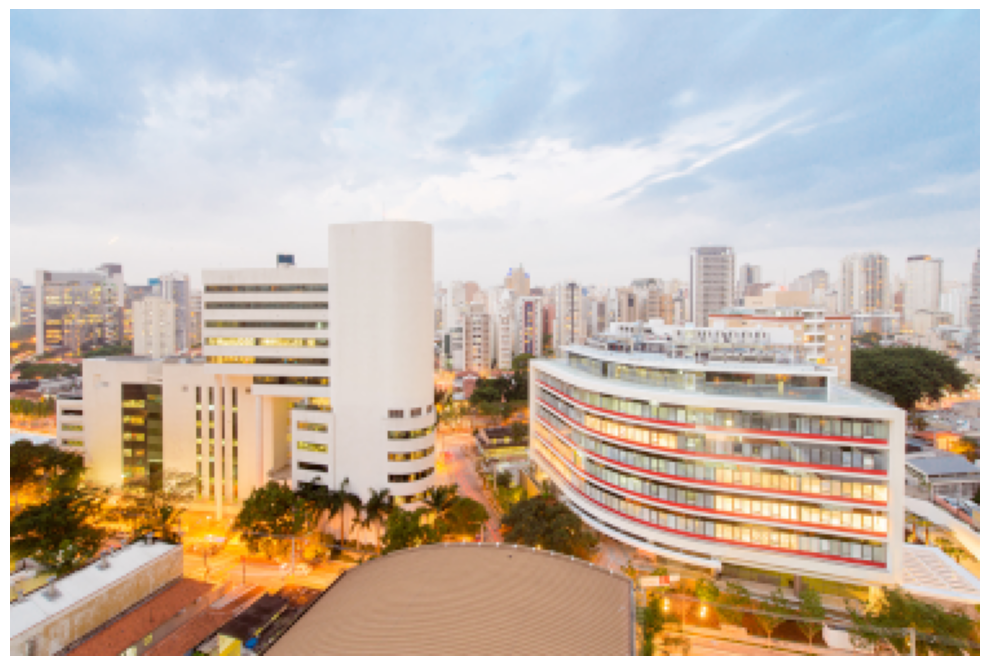

Image loaded: (250, 375, 3)


In [3]:
## read color image and do not convert to RGB
image = cv_imread('insper.png', as_rgb=False)

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv_imshow(rgb_image)

print(f"Image loaded: {image.shape}")

This image is a three-dimensional array. The third dimension represents the **color channels**. OpenCV stores images in **BGR order** (Blue, Green, Red) instead of RGB, for [historical reasons](https://learnopencv.com/why-does-opencv-use-bgr-color-format/).

In [4]:
height, width, channels = image.shape

print(f"Dimensions: {height} × {width} × {channels}")
print(f"Data type: {image.dtype}")
print(f"Value range: [{image.min()}, {image.max()}]")

Dimensions: 250 × 375 × 3
Data type: uint8
Value range: [0, 255]


---
## Part 1 — Segmenting the Sky in BGR

**Task:** Try to identify all pixels that belong to the sky.

**Approach:** We'll look for pixels close to cyan (the sky color) using Euclidean distance in BGR color space.

### Defining the Target Color

In BGR, cyan is `(255, 255, 0)` — high blue, high green, zero red.

In [5]:
cyan = np.array([255, 255, 0])  # BGR format

print(f"Target color (BGR): {cyan}")
print(f"This is cyan: high blue + high green, no red")

Target color (BGR): [255 255   0]
This is cyan: high blue + high green, no red


### Distance Function

We'll measure how close each pixel is to cyan using Euclidean distance. We normalize by 255 so distances are in the range [0, √3].

In [6]:
def distance_bgr(pixel, target):
    """
    Compute normalized Euclidean distance between two BGR pixels.
    
    Args:
        pixel: BGR pixel as (B, G, R) in [0, 255]
        target: target BGR color as (B, G, R) in [0, 255]
    
    Returns:
        Distance in [0, sqrt(3)] (normalized to [0, 1] range per channel)
    """
    return np.linalg.norm((pixel - target) / 255.0)

# Test it
test_pixel = np.array([200, 220, 50])  # Sky-ish color
print(f"Distance from cyan to {test_pixel}: {distance_bgr(test_pixel, cyan):.3f}")

Distance from cyan to [200 220  50]: 0.322


### Attempt 1: Segment Using BGR Distance

Let's try a threshold of 1.0 — any pixel within distance 1.0 of cyan is considered "sky".

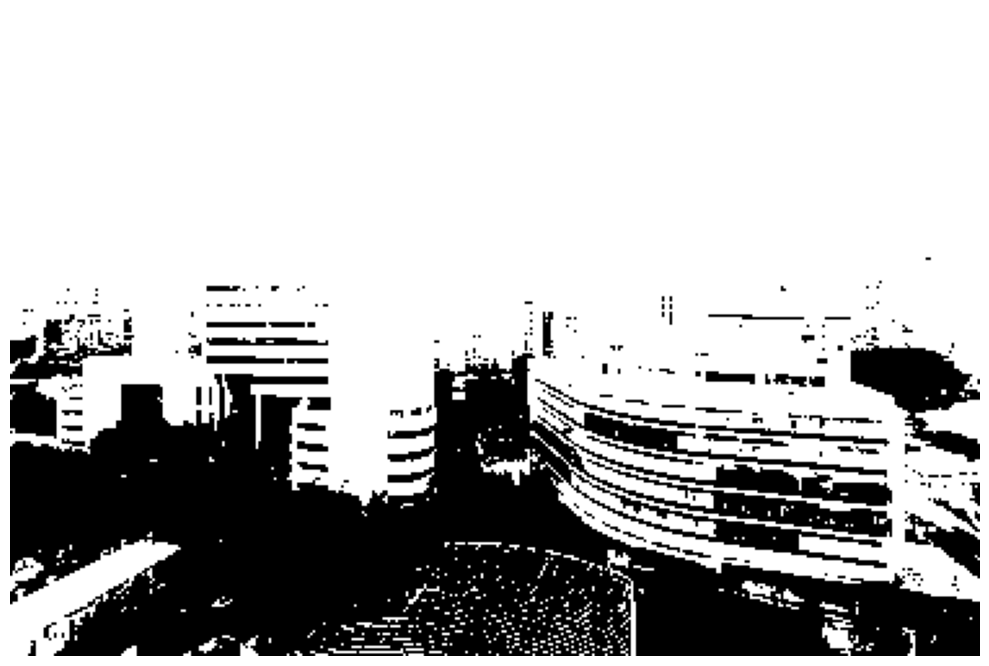

Threshold: 1.0
Sky pixels detected: 65,012 / 93,750


In [7]:
threshold = 1.0

# Create binary mask
output = np.zeros((height, width), dtype=np.uint8)

for y in range(height):
    for x in range(width):
        if distance_bgr(image[y, x], cyan) < threshold:
            output[y, x] = 255

cv_imshow(output)
print(f"Threshold: {threshold}")
print(f"Sky pixels detected: {np.sum(output == 255):,} / {height * width:,}")

### 🤔 Observation

That's not very good. We either:
- Select too many pixels (false positives — grass, buildings)
- Select too few pixels (false negatives — parts of sky missing)

**Why?** BGR is not perceptually uniform. Similar-looking colors can be far apart in BGR space, and different-looking colors can be close together.

Let's try other color spaces.

---
## Part 2 — Using the HSV Color Space

**HSV = Hue, Saturation, Value**

- **Hue:** The color type (red, green, blue, etc.) — represented as an angle [0°, 360°]
- **Saturation:** How pure/vivid the color is [0, 1] — low = grayish, high = vivid
- **Value:** How bright the color is [0, 1] — low = dark, high = bright

HSV separates *what color* (hue) from *how vivid* (saturation) and *how bright* (value). This often makes color-based segmentation easier.

### Convert to HSV

In [8]:
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

print(f"HSV image shape: {hsv.shape}")
print(f"HSV dtype: {hsv.dtype}")
print(f"Sample pixel (BGR): {image[100, 200]}")
print(f"Sample pixel (HSV): {hsv[100, 200]}")

HSV image shape: (250, 375, 3)
HSV dtype: uint8
Sample pixel (BGR): [234 232 234]
Sample pixel (HSV): [150   2 234]


⚠️ **Important:** Don't use `cv_imshow()` on the HSV image directly! It will look weird because `cv_imshow()` expects BGR format. The HSV values are correct, just not meant for direct visualization.

### ✏️ Activity 1 — Normalize HSV Values

OpenCV stores HSV in a specific range. Read the [BGR to HSV documentation](https://docs.opencv.org/4.x/de/d25/imgproc_color_conversions.html#color_convert_rgb_hsv) and write a function that normalizes HSV pixels to standard ranges:

- **H:** [0, 360] degrees
- **S:** [0, 1]
- **V:** [0, 1]

**Hint:** OpenCV uses 8-bit storage, so values are scaled to fit in [0, 255].

In [9]:
def normalize_hsv(pixel):
    """
    Normalize HSV pixel from OpenCV's storage format to standard ranges.
    
    Args:
        pixel: HSV pixel from OpenCV (H, S, V) in OpenCV's range
    
    Returns:
        (h, s, v) tuple where:
            h: float in [0, 360] (degrees)
            s: float in [0, 1]
            v: float in [0, 1]
    
    TODO: Read OpenCV documentation and implement this function.
    Hint: OpenCV stores H in [0, 180], S in [0, 255], V in [0, 255]
    """
    # ── Your code here ──────────────────────────────────────────────────────
    h, s, v = pixel
    h = h * 2
    s = s * 255
    v = v * 255
    return h, s, v  # Replace with correct normalization
    # ────────────────────────────────────────────────────────────────────────

# Test your function
test_hsv = hsv[100, 200]
h, s, v = normalize_hsv(test_hsv)
print(f"\nTest pixel (OpenCV format): {test_hsv}")
print(f"Normalized: H={h:.1f}°, S={s:.3f}, V={v:.3f}")
print("\n✓ If H is in [0, 360], S in [0, 1], V in [0, 1], you're correct!")


Test pixel (OpenCV format): [150   2 234]
Normalized: H=44.0°, S=254.000, V=22.000

✓ If H is in [0, 360], S in [0, 1], V in [0, 1], you're correct!


/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_75856/1121419386.py:19: RuntimeWarning: overflow encountered in scalar multiply
  h = h * 2
/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_75856/1121419386.py:20: RuntimeWarning: overflow encountered in scalar multiply
  s = s * 255
/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_75856/1121419386.py:21: RuntimeWarning: overflow encountered in scalar multiply
  v = v * 255


### Segment Using HSV

Now try to segment the sky using HSV thresholds. The sky is typically:
- **Hue:** Around 180-220° (cyan/blue range)
- **Saturation:** Medium to high (0.3-1.0) — it's a vivid color
- **Value:** Medium to high (0.4-1.0) — it's bright

Use Google's [color picker](https://www.google.com/search?q=color+picker) to experiment with HSV values and find good thresholds.

/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_75856/1121419386.py:20: RuntimeWarning: overflow encountered in scalar multiply
  s = s * 255
/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_75856/1121419386.py:21: RuntimeWarning: overflow encountered in scalar multiply
  v = v * 255
/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_75856/1121419386.py:19: RuntimeWarning: overflow encountered in scalar multiply
  h = h * 2


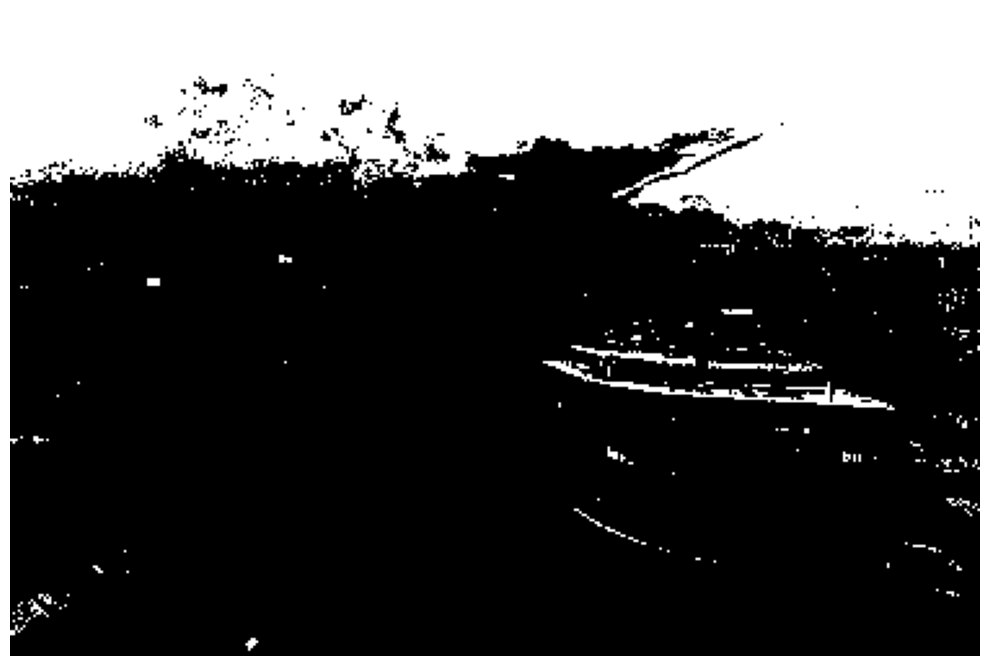

Sky pixels detected: 25,932 / 93,750


In [10]:
output = np.zeros((height, width), dtype=np.uint8)

for y in range(height):
    for x in range(width):
        h, s, v = normalize_hsv(hsv[y, x])
        
        # ── Your thresholds here ────────────────────────────────────────────
        # Replace this trivial condition with one based on h, s, v
        # Example: if 180 < h < 220 and s > 0.3 and v > 0.4:
        if 150 < h < 220 and s > 0.1 and v > 0.3:
        # ────────────────────────────────────────────────────────────────────
            output[y, x] = 255

cv_imshow(output)
print(f"Sky pixels detected: {np.sum(output == 255):,} / {height * width:,}")

**Goal:** Try to isolate just the sky. Experiment with different threshold ranges!

**Tips:**
- If you get too many false positives (grass, buildings), make your ranges tighter
- If you get too many false negatives (missing sky), make your ranges wider
- Hue is circular (0° and 360° are the same color — red)

---
## Part 3 — Using the HLS Color Space

**HLS = Hue, Lightness, Saturation**

Similar to HSV, but uses **Lightness** instead of Value:
- **Hue:** Same as HSV [0°, 360°]
- **Lightness:** How light/dark [0, 1] — 0 = black, 0.5 = pure color, 1 = white
- **Saturation:** How pure the color is [0, 1]

HLS is sometimes better for tasks involving lighting variations.

⚠️ **Note:** OpenCV calls it "HLS" not "HSL" (different ordering of letters).

In [11]:
hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

print(f"HLS image shape: {hls.shape}")
print(f"Sample pixel (BGR): {image[100, 200]}")
print(f"Sample pixel (HLS): {hls[100, 200]}")

HLS image shape: (250, 375, 3)
Sample pixel (BGR): [234 232 234]
Sample pixel (HLS): [150 233  12]


### ✏️ Activity 2 — Normalize HLS Values

Read the [BGR to HLS documentation](https://docs.opencv.org/4.x/de/d25/imgproc_color_conversions.html#color_convert_rgb_hls) and write a normalization function for HLS:

- **H:** [0, 360] degrees
- **L:** [0, 1]
- **S:** [0, 1]

In [12]:
def normalize_hls(pixel):
    """
    Normalize HLS pixel from OpenCV's storage format to standard ranges.
    
    Args:
        pixel: HLS pixel from OpenCV (H, L, S) in OpenCV's range
    
    Returns:
        (h, l, s) tuple where:
            h: float in [0, 360] (degrees)
            l: float in [0, 1]
            s: float in [0, 1]
    
    TODO: Implement this based on OpenCV documentation.
    """
    h, l, s = pixel
    
    # ── Your code here ──────────────────────────────────────────────────────
    h = h * 2
    l =  l / 255
    s = s / 255
    return h, l, s  # Replace with correct normalization
    # ────────────────────────────────────────────────────────────────────────

# Test
test_hls = hls[100, 200]
h, l, s = normalize_hls(test_hls)
print(f"\nTest pixel (OpenCV format): {test_hls}")
print(f"Normalized: H={h:.1f}°, L={l:.3f}, S={s:.3f}")


Test pixel (OpenCV format): [150 233  12]
Normalized: H=44.0°, L=0.914, S=0.047


/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_75856/3660081455.py:19: RuntimeWarning: overflow encountered in scalar multiply
  h = h * 2


### Segment Using HLS

Now try segmenting the sky using HLS thresholds.

/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_75856/3660081455.py:19: RuntimeWarning: overflow encountered in scalar multiply
  h = h * 2


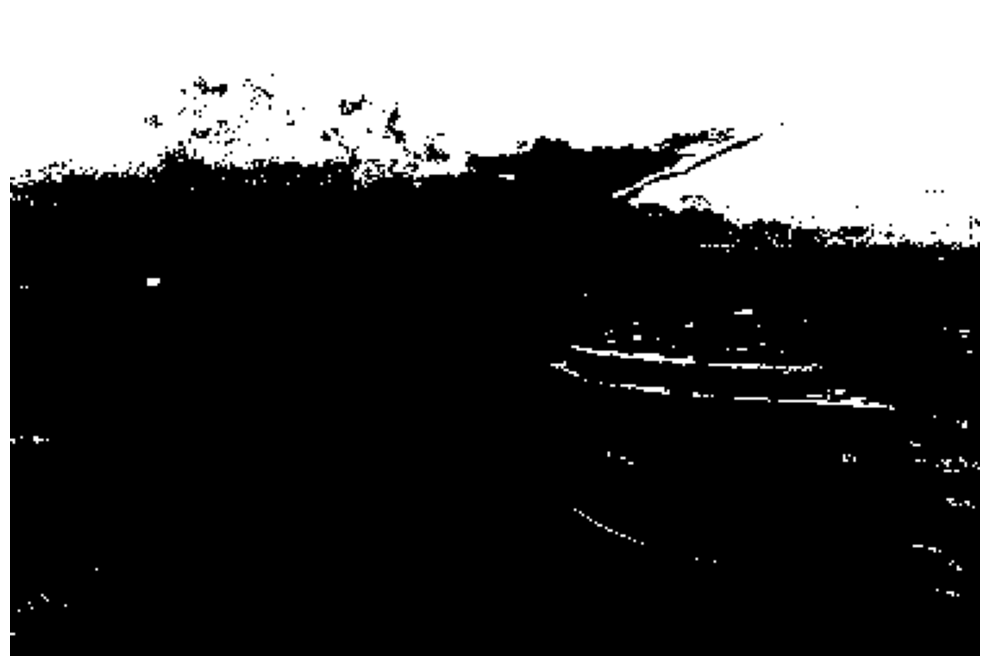

Sky pixels detected: 25,461 / 93,750


In [13]:
output = np.zeros((height, width), dtype=np.uint8)

for y in range(height):
    for x in range(width):
        h, l, s = normalize_hls(hls[y, x])
        
        # ── Your thresholds here ────────────────────────────────────────────
        if 150 < h < 220 and l > 0.5 and s > 0.1:
        # ────────────────────────────────────────────────────────────────────
            output[y, x] = 255

cv_imshow(output)
print(f"Sky pixels detected: {np.sum(output == 255):,} / {height * width:,}")

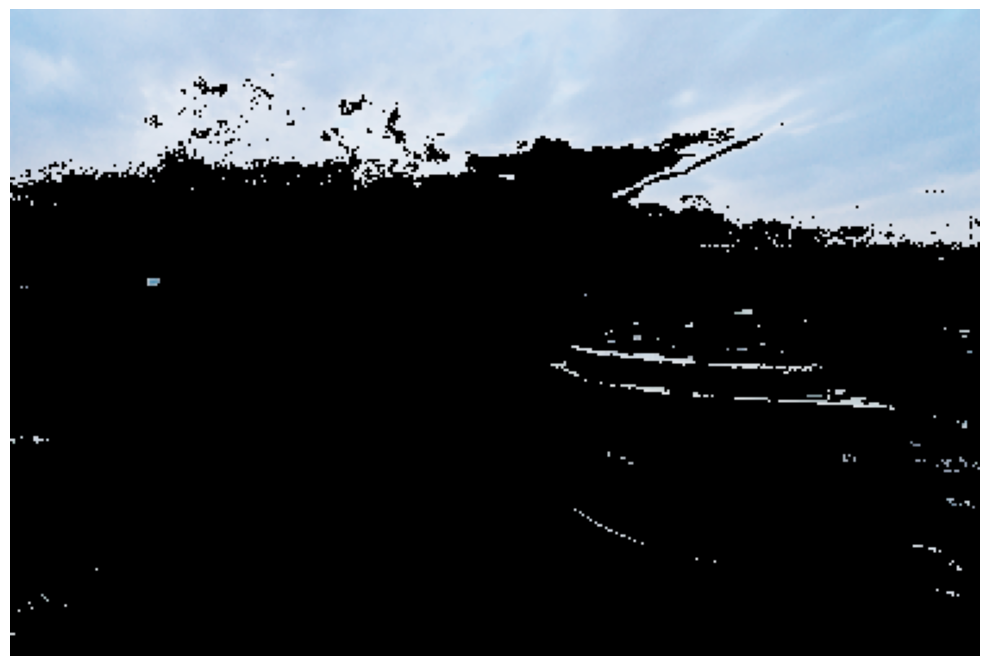

In [14]:
rgb_masked = cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)
result = rgb_masked * (output[:, :, np.newaxis] / 255.0)
cv_imshow(result.astype(np.uint8))

**Question to think about:** Does HLS work better than HSV for this image? Why or why not?

It does. The sky is a light color, so using Lightness helps separate it from darker objects like grass and buildings. HSV's Value doesn't capture this as well

---
## Part 4 — Using the Lab Color Space

**Lab = Lightness, a, b**

Lab is designed to be **perceptually uniform** — equal distances in Lab space correspond to equal perceived color differences.

- **L:** Lightness [0, 100]
- **a:** Green (-) to Red (+) axis
- **b:** Blue (-) to Yellow (+) axis

Lab is often used in color science and can be better for color matching tasks.

In [15]:
lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

print(f"Lab image shape: {lab.shape}")
print(f"Sample pixel (BGR): {image[100, 200]}")
print(f"Sample pixel (Lab): {lab[100, 200]}")

Lab image shape: (250, 375, 3)
Sample pixel (BGR): [234 232 234]
Sample pixel (Lab): [235 129 127]


### ✏️ Activity 3 — Normalize Lab Values

Read the [BGR to Lab documentation](https://docs.opencv.org/4.x/de/d25/imgproc_color_conversions.html#color_convert_rgb_lab) and normalize Lab values:

- **L:** [0, 100]
- **a:** [-127, 127] (green to red)
- **b:** [-127, 127] (blue to yellow)

In [16]:
def normalize_lab(pixel):
    """
    Normalize Lab pixel from OpenCV's storage format to standard ranges.
    
    Args:
        pixel: Lab pixel from OpenCV (L, a, b) in OpenCV's range
    
    Returns:
        (L, a, b) tuple where:
            L: float in [0, 100]
            a: float in [-127, 127]
            b: float in [-127, 127]
    
    TODO: Implement this. Careful with the a and b channels!
    """
    L, a, b = pixel
    
    # ── Your code here ──────────────────────────────────────────────────────
    L = L * 100.0 / 255.0 
    a = a - 128.0         
    b = b - 128.0         

    return L, a, b  # Replace with correct normalization
    # ────────────────────────────────────────────────────────────────────────

# Test
test_lab = lab[100, 200]
L, a, b = normalize_lab(test_lab)
print(f"\nTest pixel (OpenCV format): {test_lab}")
print(f"Normalized: L={L:.1f}, a={a:.1f}, b={b:.1f}")


Test pixel (OpenCV format): [235 129 127]
Normalized: L=92.2, a=1.0, b=-1.0


### Segment Using Lab

Try segmenting the sky in Lab space. 

**Hints for sky:**
- L: Medium to high (bright)
- a: Negative or near zero (no red, some green)
- b: Negative (blue, not yellow)

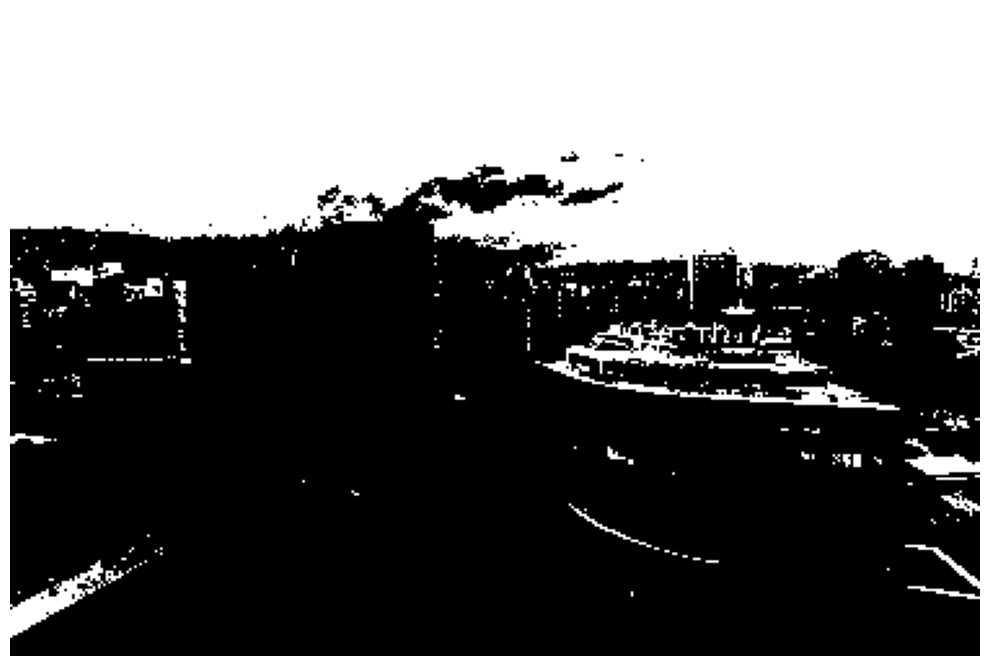

Sky pixels detected: 36,042 / 93,750


In [17]:
output = np.zeros((height, width), dtype=np.uint8)

for y in range(height):
    for x in range(width):
        L, a, b = normalize_lab(lab[y, x])
        
        # ── Your thresholds here ────────────────────────────────────────────
        if 50 < L < 100 and a < 10 and b < 0:
        # ────────────────────────────────────────────────────────────────────
            output[y, x] = 255

cv_imshow(output)
print(f"Sky pixels detected: {np.sum(output == 255):,} / {height * width:,}")

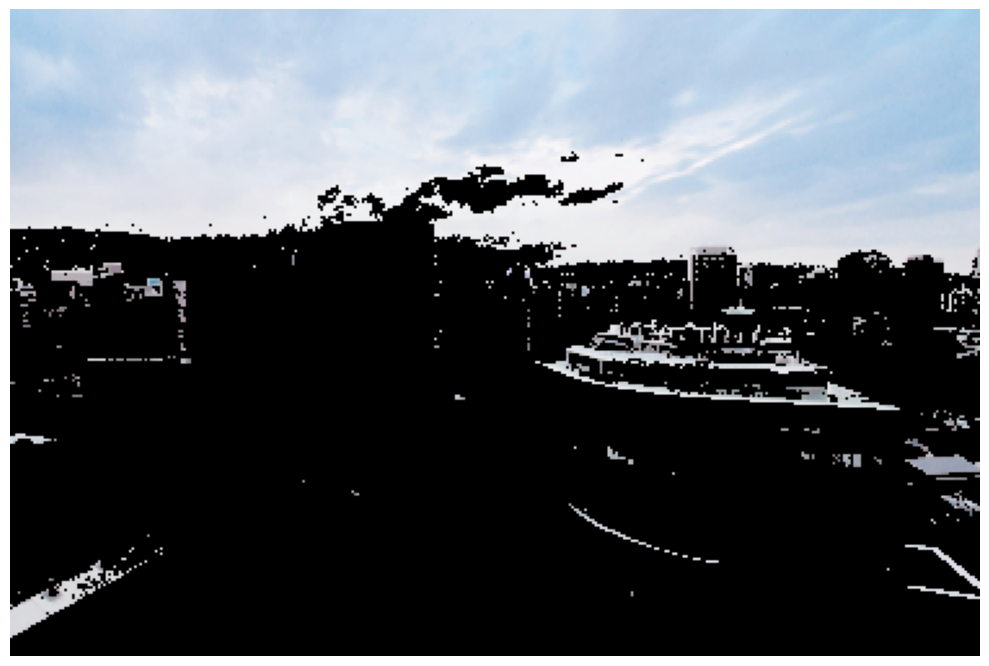

In [18]:
rgb_masked = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
result = rgb_masked * (output[:, :, np.newaxis] / 255.0)
cv_imshow(result.astype(np.uint8))

---
## Part 5 — Converting to Grayscale

Finally, let's explore how to properly convert a color image to grayscale.

### Extracting Color Channels

First, let's split the BGR image into its three channels:

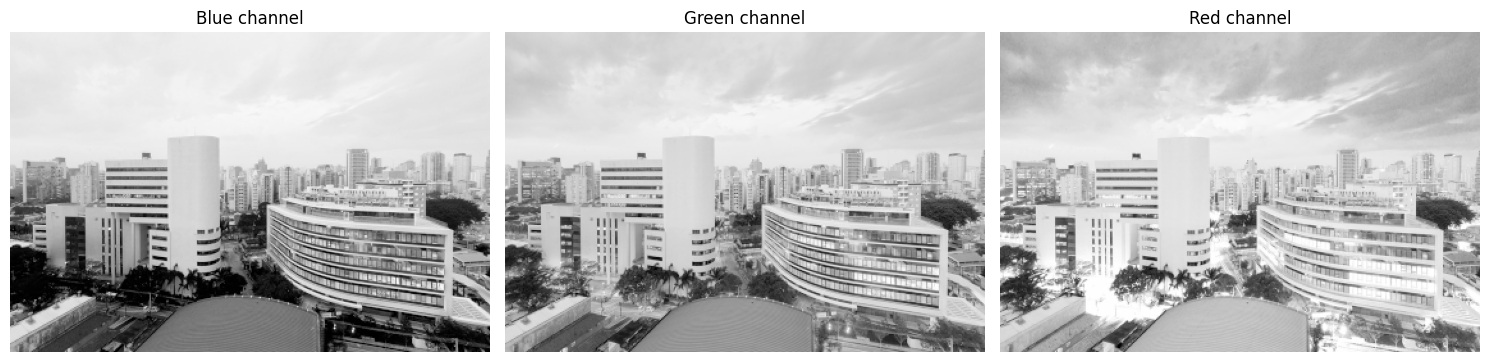

Each channel shape: (250, 375)
Each channel dtype: uint8


In [19]:
b, g, r = cv2.split(image)

# Display each channel
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(b, cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Blue channel')
axes[0].axis('off')

axes[1].imshow(g, cmap='gray', vmin=0, vmax=255)
axes[1].set_title('Green channel')
axes[1].axis('off')

axes[2].imshow(r, cmap='gray', vmin=0, vmax=255)
axes[2].set_title('Red channel')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Each channel shape: {b.shape}")
print(f"Each channel dtype: {b.dtype}")

### Naive Approach: Average the Channels

The simplest approach is to average the three channels:

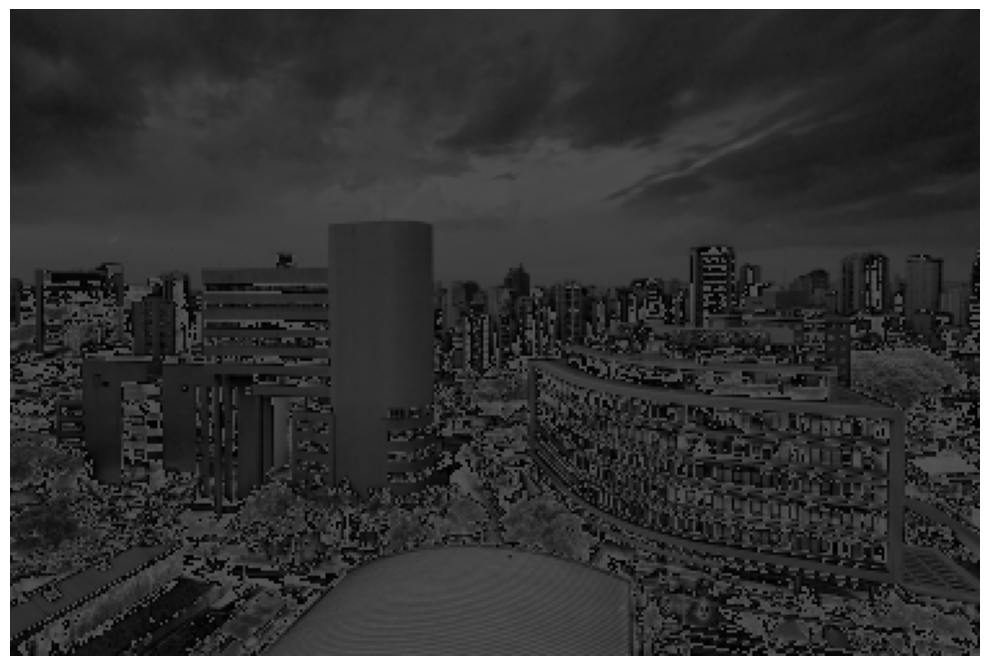

Gray image dtype: float64
Gray image range: [0.0, 85.0]
[[31.         32.66666667 33.         ... 28.66666667 28.33333333
  29.        ]
 [32.66666667 32.33333333 31.         ... 29.         27.66666667
  28.33333333]
 [31.66666667 31.         30.33333333 ... 29.66666667 27.33333333
  28.        ]
 ...
 [ 9.         10.          5.66666667 ... 55.         50.33333333
  58.        ]
 [15.         14.66666667  7.66666667 ... 64.66666667 60.33333333
  60.66666667]
 [15.         13.66666667 10.33333333 ... 75.         76.33333333
  78.66666667]]


In [25]:
# Naive grayscale conversion
gray = (r + g + b) / 3

cv_imshow(gray)

print(f"Gray image dtype: {gray.dtype}")
print(f"Gray image range: [{gray.min():.1f}, {gray.max():.1f}]")
print(gray)

### 🐛 Challenge 1 — Fix the Bug

Something is wrong! The image has weird artifacts. 

**Your task:**
1. Figure out what went wrong
2. Fix the code below
3. Explain why the original code failed

**Hint:** Check the data types involved.

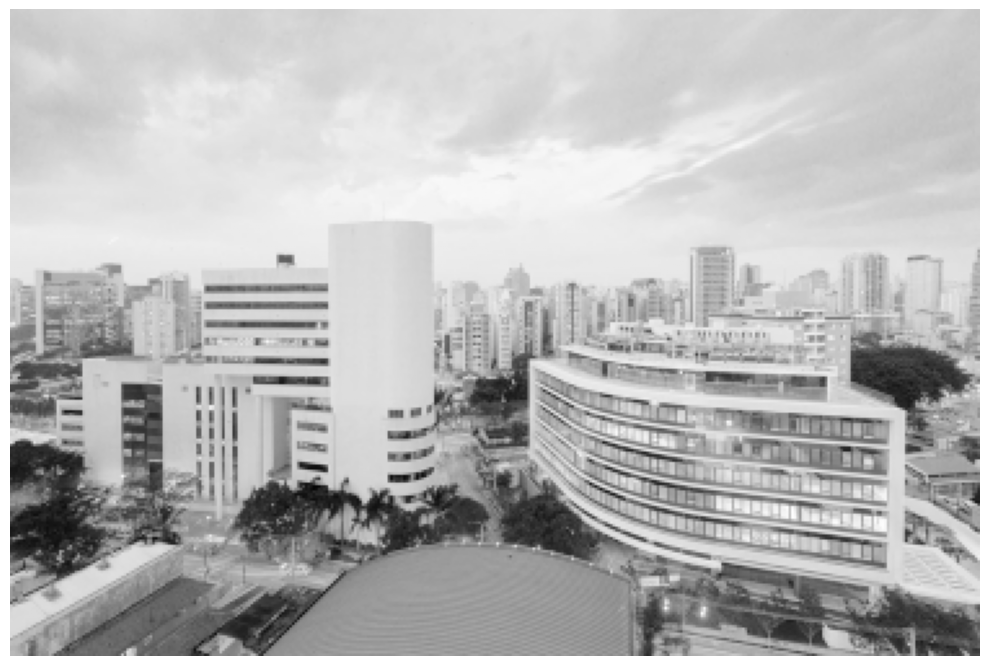

In [26]:
# ── Fix this code ──────────────────────────────────────────────────────────
gray = (r / 3 + g / 3 + b / 3)# What's wrong here?
# ────────────────────────────────────────────────────────────────────────────

cv_imshow(gray)

**Explanation (write your answer here):**

*Why did the original code fail?*

Because in the original code, there can be an overflow due to adding two uint8 vals that equal greater than 255. In that case, the result is the remainder after dividing by 256, which is not the right average, thus causing the artifacts
...

*What did you change to fix it?*

Dividing each value by three before adding, ensuring that the sum does not exceed 255 and therefore avoiding overflow
...

### OpenCV's Grayscale Conversion

Even with the bug fixed, your result might look slightly different from OpenCV's conversion:

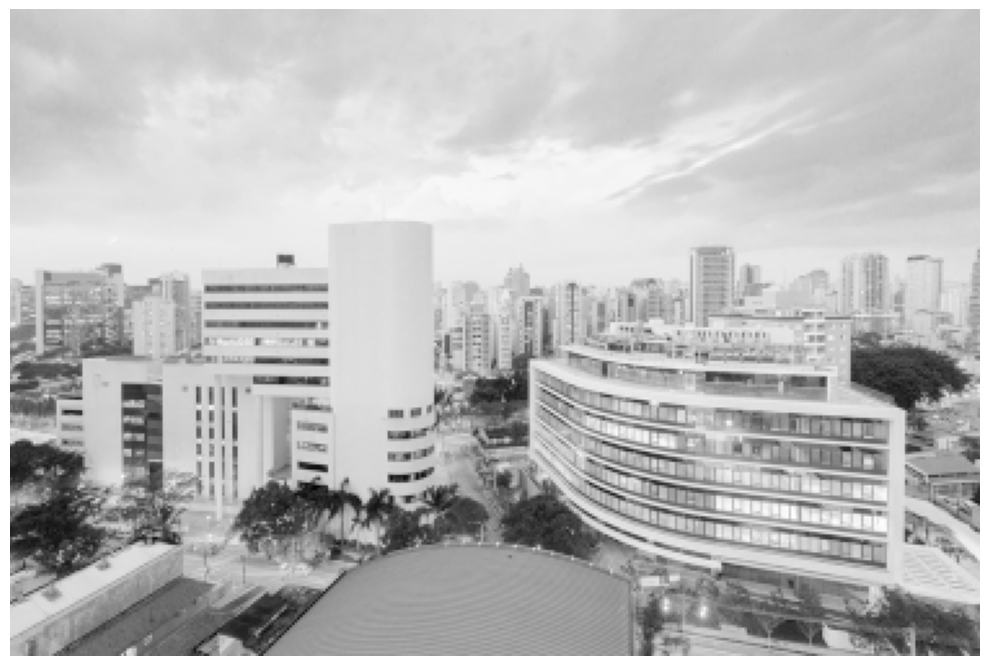

Compare the two grayscale images carefully.
Can you see the difference? It's subtle but present.


In [ ]:
# OpenCV's built-in grayscale conversion
opencv_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

cv_imshow(opencv_gray)

print("Compare the two grayscale images carefully.")
print("Can you see the difference? It's subtle but present.")

### 🔬 Challenge 2 — OpenCV's Secret

OpenCV doesn't simply average the three channels. It uses a **weighted** formula.

**Your tasks:**
1. Research what formula OpenCV uses for BGR → grayscale
2. Implement it below
3. Explain **why** OpenCV uses this specific formula (hint: human vision)

**Hint:** Search for "ITU-R BT.601" or look at OpenCV's color conversion documentation.

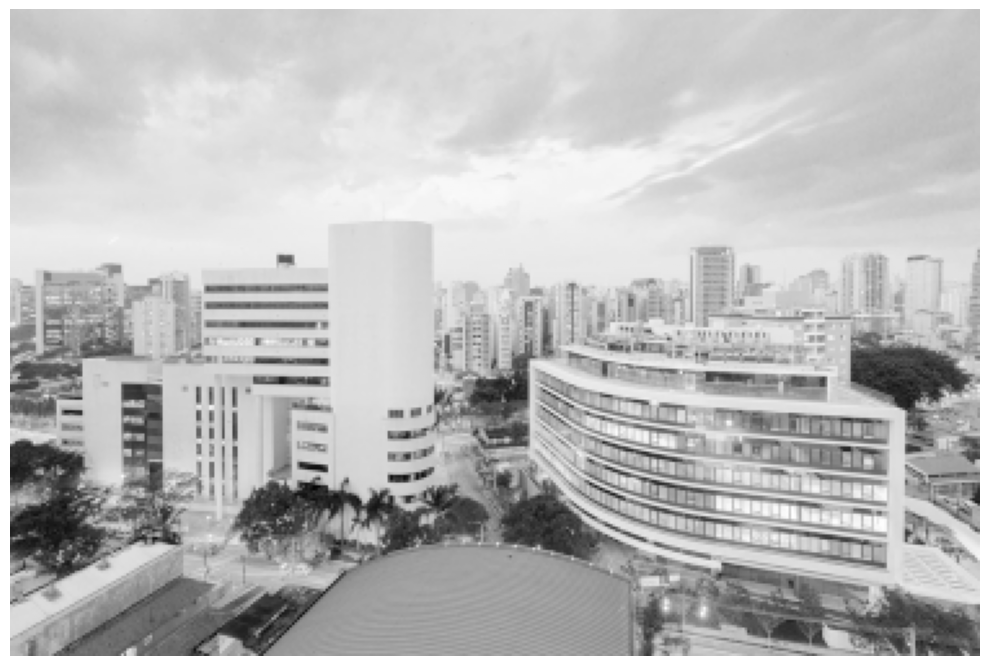


Max difference from OpenCV: 0.50
Mean difference: 0.24

If max difference < 1.0, your formula is correct!


In [ ]:
# ── Implement OpenCV's weighted grayscale conversion ───────────────────────
gray = (r * 0.299 + g * 0.587 + b * 0.114)
# ────────────────────────────────────────────────────────────────────────────

cv_imshow(gray)

# Compare to OpenCV's result
opencv_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

difference = np.abs(gray.astype(float) - opencv_gray.astype(float))
print(f"\nMax difference from OpenCV: {difference.max():.2f}")
print(f"Mean difference: {difference.mean():.2f}")
print("\nIf max difference < 1.0, your formula is correct!")

**Explanation (write your answer here):**

*What formula does OpenCV use?*

0.299⋅R+0.587⋅G+0.114⋅B


*Why this formula? (Hint: Which color are human eyes most sensitive to?)*

The human eye is most sensitive to green light, so the formula weights green more heavily than red or blue. The formula is used to balance the contribution of each color channel to match our perception of them

---
## Summary and Reflection

### What You Learned

Today you explored multiple color spaces:

| Color Space | When to Use |
|-------------|-------------|
| **BGR/RGB** | Natural representation, but not perceptually uniform |
| **HSV** | When you want to separate color (hue) from brightness; good for color-based segmentation |
| **HLS** | Similar to HSV, but with different brightness representation |
| **Lab** | When perceptual uniformity matters; good for color matching |

### Key Takeaways

1. **BGR is not always best** — Different color spaces are better for different tasks
2. **Hue separates "what color"** from "how bright" — very useful for segmentation
3. **Lab is perceptually uniform** — equal distances = equal perceived differences
4. **Weighted grayscale** matches human perception better than simple averaging

### ✏️ Final Reflection

Answer these questions:

1. Which color space worked best for segmenting the sky? Why?
2. When might you prefer HSV over Lab (or vice versa)?
3. How does this lab connect to Lab 3 (where brightness changes broke your model)?
4. Can you think of a computer vision task where color space choice would be critical?

In [34]:
# Your reflection answers:

# 1. Best color space for sky segmentation:
#    Lab, because it separetes the lightness from the color information, making it so that we can both color and brightness to segment the sky on the thresholds

# 2. When to prefer HSV vs Lab:
#    HSV is preferred when you want to work with hue and saturation directly, such as for color-based segmentation. Lab is better when you want to separate lightness from color, which can be useful for tasks like sky segmentation where brightness can vary

# 3. Connection to Lab 3:
#    Lab 3 talked abou how image transformations (blurr, rotation, etc) can affect the results of predictions of computer vision models. In this lab, we learned a different type of transformation (color space) that can also affect the results of computer vision tasks 

# 4. A task where color space matters:
#    Tracking an object based on its color, where using the right color space (like HSV) can be very beneficial


---
## 📋 Submission Checklist

Before submitting, make sure:

- [ ] Activity 1: `normalize_hsv()` implemented correctly
- [ ] HSV sky segmentation attempted with thresholds
- [ ] Activity 2: `normalize_hls()` implemented correctly
- [ ] HLS sky segmentation attempted
- [ ] Activity 3: `normalize_lab()` implemented correctly
- [ ] Lab sky segmentation attempted
- [ ] Challenge 1: Grayscale bug fixed with explanation
- [ ] Challenge 2: Weighted grayscale formula implemented with explanation
- [ ] Final reflection questions answered
- [ ] All cells executed in order

**Above average:** Achieve excellent sky segmentation in any color space (minimal false positives/negatives)